<a href="https://colab.research.google.com/github/yoheshkannan/ML/blob/master/Univariate_Time_Series_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle (1).json


In [30]:
!pip install -q kaggle

In [31]:
!mkdir -p ~/.kaggle

In [32]:
!cp kaggle.json ~/.kaggle/

In [33]:
!chmod 600 ~/.kaggle/kaggle.json

In [34]:
!kaggle datasets download -d limkongkong/airpassengers

airpassengers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [35]:
from zipfile import ZipFile
file_name = 'airpassengers.zip'

In [36]:
with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [37]:
import pandas as pd

In [38]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [39]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [40]:
df.columns = ['#months', '#Passengers']
df.head()

,#months,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [41]:
df['#months'] = pd.to_datetime(df['#months'])

In [42]:
df.isna().sum()

#months        0
#Passengers    0
dtype: int64

In [43]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [115]:
import matplotlib.pyplot as plt

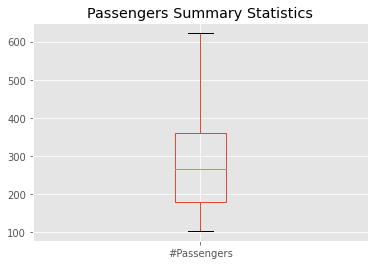

In [116]:
plt.style.use('ggplot')
ax = df.boxplot()
ax.set_title('Passengers Summary Statistics')
plt.show()

In [117]:
from numpy import array
import numpy as np
from sklearn.preprocessing import MinMaxScaler
dataset = df['#Passengers'].values
dataset = dataset.reshape(-1,1)
scalar = MinMaxScaler(feature_range=(0,1))
dataset = scalar.fit_transform(dataset)
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size

In [118]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:] 

In [131]:
def data_preprocess(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [183]:
look_back = 30
X_train, y_train = data_preprocess(train, look_back)
X_test, y_test = data_preprocess(test, look_back)

In [184]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [185]:
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras.callbacks import EarlyStopping
#from keras.layers import Bidirectional

In [186]:
model = Sequential()
model.add(LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [187]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               52400     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 57,501
Trainable params: 57,501
Non-trainable params: 0
_________________________________________________________________


In [188]:
history  = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=EarlyStopping(monitor = 'val_loss',patience =10), verbose = 1)

Epoch 1/50
3/3 [==============================] - 0s 134ms/step - loss: 0.0793 - val_loss: 0.2588
Epoch 2/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0402 - val_loss: 0.1157
Epoch 3/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0333
Epoch 4/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0084 - val_loss: 0.0356
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 0.0120 - val_loss: 0.0583
Epoch 6/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0465
Epoch 7/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0281
Epoch 8/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0231
Epoch 9/50
3/3 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0321
Epoch 10/50
3/3 [==============================] - 0s 7ms/step - loss: 0.0089 - val_loss: 0.0391
Epoch 11/50
3/3 [===================

In [189]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scalar.inverse_transform(train_predict)
y_train = scalar.inverse_transform([y_train])
test_predict = scalar.inverse_transform(test_predict)
y_test = scalar.inverse_transform([y_test])

In [190]:
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

Train Root Mean Squared Error: 22.404888
Test Root Mean Squared Error: 28.98312


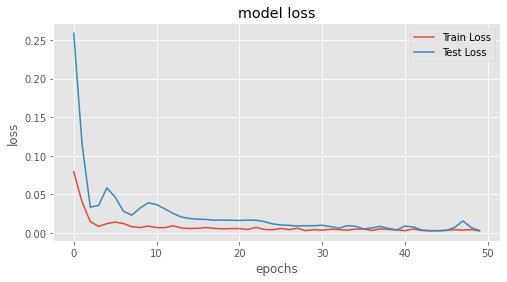

In [191]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

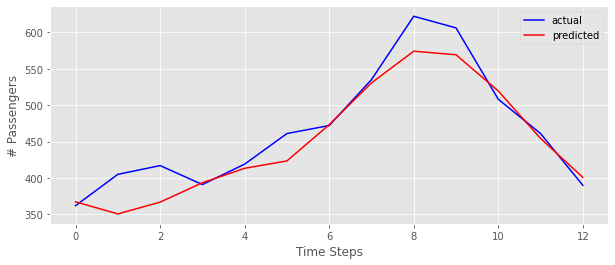

In [192]:
plt.figure(figsize=(10,4))
plt.plot(y_test[0], color='blue', label ='actual')
plt.plot(test_predict, color ='red', label ='predicted')
plt.xlabel('Time Steps')
plt.ylabel('# Passengers')
plt.legend()
plt.show()